In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure as fig
from pylab import rcParams
import datetime
from datetime import timedelta
import statsmodels.api as sm
rcParams['figure.figsize'] = 20,10
from ResearchClass import PlotEvaluations, EvaluationMetrics, TradesBook, StrategyTemplate
import os

pd.options.mode.chained_assignment = None  # default='warn'


        Assets:		 ['data/MNQc1.parquet']
        Start date:	 2024-11-27 00:00:00
        End date:	 2025-01-25 00:00:00
        Frequency: 	 2m
        ---------------------------
        trade_df:		 147
        Costs: 		 $470.40000000000003/month
        Sharpe:		 -8.954 
        Sortino:	 -9.426 
        t-stat:		 -14.014
        Total return: 	 96.545%
        Win rate:	 3.4%
        Avg trade:	 -0.024%
        Avg win:	 0.011% 
        Avg loss:	 -0.025%
        Min trade size:	 $-1967110
        Avg trade time:	 5998.931972789115
        Avg win time:	 83.8
        Avg loss time:	 6207.211267605634
        


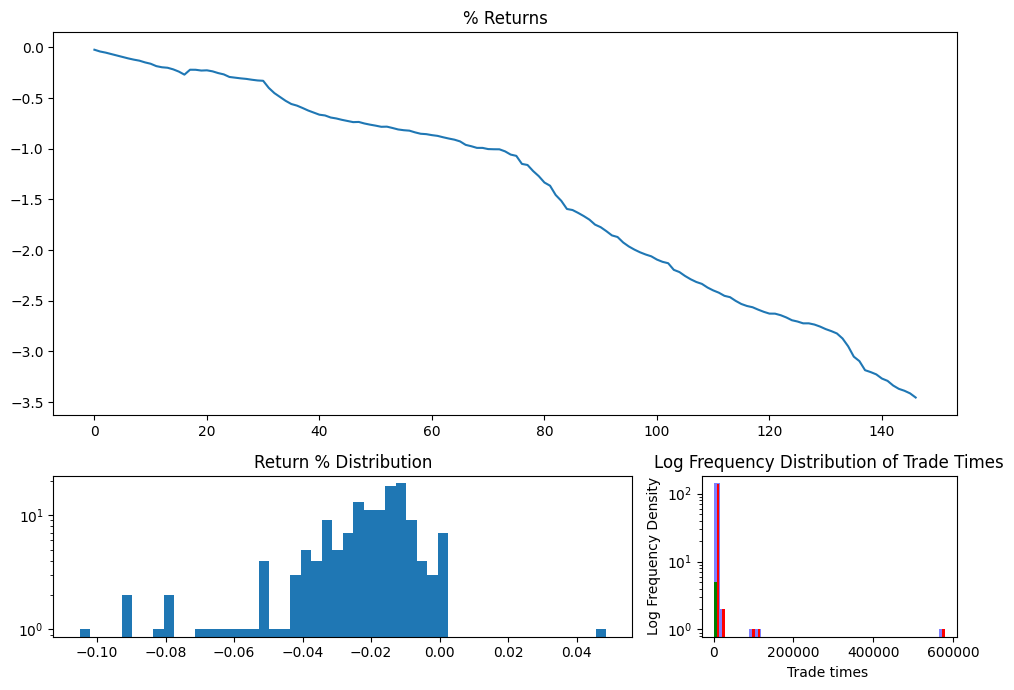

In [11]:
class AMCrossover(StrategyTemplate):
    """
    AMCrossover strategy class that inherits from StrategyTemplate.
    This strategy uses a simple moving average (SMA) crossover to generate buy and sell signals.
    It also includes Bollinger Bands and RSI for enhanced decision-making.
    """

    def AddIndicators(self):
        """
        Adds the necessary indicators to the data.
        Specifically, it calculates the short and long period SMAs, Bollinger Bands, and RSI.
        """
        SHORT_LOOKBACK_PERIOD = self.indicator_parameters[0]
        LONG_LOOKBACK_PERIOD = self.indicator_parameters[1]
        RSI_PERIOD = 14  # Common period for RSI calculation
        BBAND_PERIOD = 20  # Common period for Bollinger Bands
        BBAND_MULTIPLIER = 2  # Multiplier for standard deviation to calculate upper and lower bands

        # Calculate short and long SMAs
        self.data['SMA_SHORT'] = self.data['Close'].rolling(SHORT_LOOKBACK_PERIOD).mean()
        self.data['SMA_LONG'] = self.data['Close'].rolling(LONG_LOOKBACK_PERIOD).mean()

        # Calculate Bollinger Bands
        self.data['SMA_BB'] = self.data['Close'].rolling(BBAND_PERIOD).mean()  # Middle band (SMA)
        self.data['BB_upper'] = self.data['SMA_BB'] + (self.data['Close'].rolling(BBAND_PERIOD).std() * BBAND_MULTIPLIER)  # Upper band
        self.data['BB_lower'] = self.data['SMA_BB'] - (self.data['Close'].rolling(BBAND_PERIOD).std() * BBAND_MULTIPLIER)  # Lower band

        # Calculate RSI
        delta = self.data['Close'].diff()  # Price difference between consecutive periods
        gain = (delta.where(delta > 0, 0)).rolling(RSI_PERIOD).mean()  # Calculate gains
        loss = (-delta.where(delta < 0, 0)).rolling(RSI_PERIOD).mean()  # Calculate losses
        RS = gain / loss  # Relative Strength
        self.data['RSI'] = 100 - (100 / (1 + RS))  # RSI formula

    def strategyLogic(self, TradeBook, row, idx):
        """
        Defines the strategy logic for the AMCrossover strategy.

        Parameters:
        - TradeBook: The TradeBook object that manages trades.
        - row: The current row of data.
        - idx: The current index in the data.
        """
        # Skip the initial periods to allow for indicator warmup
        if idx < self.indicator_parameters[1]:
            return

        # Close trade if an active order execution price is met
        if TradeBook.CurrentSizing() != 0 and TradeBook.ActiveOrderExecutionPrice(row):
            TradeBook.CloseTrade(TradeBook.ActiveOrderExecutionPrice(row), idx)

        # Long trade logic - SMA crossover with RSI and Bollinger Bands filter
        if TradeBook.CurrentSizing() == 0:
            if self.data['SMA_SHORT'][idx-1] > self.data['SMA_LONG'][idx-1] and self.data['RSI'][idx-1] < 70 and row['Close'] > self.data['BB_upper'][idx-1]:
                entry = row['Open']
                stop = row['Open'] * (1 - self.indicator_parameters[2])
                target = row['SMA_LONG']
                TradeBook.OpenTrade(entry, 1, stop, idx, target)

        # Short trade logic - SMA crossover with RSI and Bollinger Bands filter
        if TradeBook.CurrentSizing() == 0:
            if self.data['SMA_SHORT'][idx-1] < self.data['SMA_LONG'][idx-1] and self.data['RSI'][idx-1] > 30 and row['Close'] < self.data['BB_lower'][idx-1]:
                entry = row['Open']
                stop = row['Open'] * (1 + self.indicator_parameters[2])
                target = row['SMA_LONG']
                TradeBook.OpenTrade(entry, -1, stop, idx, target)

# Parameters: [short lookback period, long lookback period, stop loss percentage]
parameters = [5, 20, 0.015]
ticker_list = ['data/MNQc1.parquet']
today = datetime.datetime.now()
start_date = str((today - datetime.timedelta(days=59)).strftime("%Y-%m-%d"))
end_date = str(today.strftime("%Y-%m-%d"))
interval = "2m"

# Apply the AMCrossover strategy to the specified tickers and date range
AMCROSSOVER_TRADE_BOOK = AMCrossover(ticker_list, start_date, end_date, interval, parameters).ApplyStrategyThroughTickers()

# Evaluate the strategy performance
metrics = EvaluationMetrics(AMCROSSOVER_TRADE_BOOK, ticker_list, start_date, end_date)
plots = PlotEvaluations(AMCROSSOVER_TRADE_BOOK, (10, 7))

# Print the evaluation metrics and plot the summary
metrics.print_results()
plots.PlotSummary()
